In [2]:
import pandas as pd
from tqdm import tqdm
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt

warnings.simplefilter("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [2]:
#PRED Dataframe
df_pred = pd.read_csv('roi_distance.csv', sep=',')
df_pred = df_pred.loc[:, ~df_pred.columns.str.contains('^Unnamed')]

#TRUTH Dataframe
df_gtruth = pd.read_csv('ground_truth.csv', sep=',')
df_gtruth = df_gtruth.loc[:, ~df_gtruth.columns.str.contains('^Unnamed')]
df_gtruth['image_name'] = df_gtruth['image_name'].apply(lambda x: os.path.basename(x))
df_gtruth['label_name'] = df_gtruth['label_name'].apply(lambda x: os.path.basename(x))


### Convert GroundTruth Coordinates To Pixel

In [3]:
def convert_ground_truth(df_gtruth):
    # Initialize new columns in the DataFrame
    df_gtruth['xcenter_truth'] = 0
    df_gtruth['ycenter_truth'] = 0
    df_gtruth['width_truth'] = 0
    df_gtruth['height_truth'] = 0
    df_gtruth['class_truth'] = 0
    
    for index, row in tqdm(df_gtruth.iterrows()):
        class_truth = row['class']
        image_width = row['image_width']
        image_height = row['image_height']
        xcenter_truth = int(row['xcenter'] * image_width)
        ycenter_truth = int(row['ycenter'] * image_height)
        width_truth = int(row['width'] * image_width)
        height_truth = int(row['height'] * image_height)
#       print(class_truth, xcenter_truth, ycenter_truth, width_truth, height_truth)

        # Update the new columns in the DataFrame
        df_gtruth.at[index, 'xcenter_truth'] = xcenter_truth
        df_gtruth.at[index, 'ycenter_truth'] = ycenter_truth
        df_gtruth.at[index, 'width_truth'] = width_truth
        df_gtruth.at[index, 'height_truth'] = height_truth
        df_gtruth.at[index, 'class_truth'] = class_truth
    return df_gtruth
df_gtruth = convert_ground_truth(df_gtruth)

227867it [02:07, 1792.90it/s]


In [4]:
print(df_gtruth.shape)
print(df_pred.shape)

(227867, 14)
(174786, 11)


# FInal Logic

In [34]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((abs(point1 - point2))**2))

def compare_points(point1, point2, threshold_same, threshold_different):
    distance = euclidean_distance(point1, point2)
    
    if distance < threshold_same:
        return True
    elif distance > threshold_different:
        return False
    else:
        return True

def get_close_match(df_pred_sample, df_gtruth_sample):
    image_name_list = df_pred.image_name.unique()
    threshold_same = 6.0
    threshold_different = 10.0
    close_matches = pd.DataFrame()

    all_close_matches = []
    for image_name in tqdm(image_name_list):
        for index1, row1 in df_pred_sample[df_pred_sample['image_name']==image_name][['xcenter', 'ycenter']].iterrows():
            for index2, row2 in df_gtruth_sample[df_gtruth_sample['image_name']==image_name][['xcenter_truth', 'ycenter_truth']].iterrows():
                result = compare_points(np.array(row1), np.array(row2), threshold_same, threshold_different)
                if result:
                    df_1 = df_pred_sample[['xcenter', 'ycenter', 'width', 'height','class','confidence','name','area','depth_id','depth_name','image_name']].iloc[index1]
                    df_2 = df_gtruth_sample[['xcenter_truth', 'ycenter_truth', 'width_truth', 'height_truth', 'class_truth']].iloc[index2]

                    df_11 = pd.DataFrame(df_1).transpose()
                    df_22 = pd.DataFrame(df_2).transpose()
                    close_matches = pd.concat([df_1, df_2], axis=0)
                    all_close_matches.append(close_matches)
        close_matches = pd.concat(all_close_matches, axis=1).transpose().reset_index(drop=True)
    return close_matches

# close_matches['class']= close_matches['class'].astype('int')
resultant = get_close_match(df_pred, df_gtruth) 

100%|██████████████████████████████████| 11923/11923 [20:53:07<00:00,  6.31s/it]


In [36]:
resultant.to_csv('roi_distances_updated.csv', sep=',')

In [4]:
df = pd.read_csv('roi_distances_updated.csv', sep=',')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df.head()

,xcenter,ycenter,width,height,class,confidence,name,area,depth_id,depth_name,image_name,xcenter_truth,ycenter_truth,width_truth,height_truth,class_truth
0,354.030640,680.527527,116.334442,126.692017,4,0.917122,yellow_cone,14738.645075,0,close_from_cam,gfr_00544_jpg.jpg,352,679,112,123,4
1,1556.451660,912.496704,143.378784,190.541870,0,0.911995,blue_cone,27319.661673,0,close_from_cam,gfr_00544_jpg.jpg,1556,911,140,191,0
2,688.939575,758.156433,119.413635,144.132568,2,0.901687,orange_cone,17211.393946,0,close_from_cam,gfr_00544_jpg.jpg,689,756,122,145,2
3,1153.819580,710.862671,111.585693,122.757141,4,0.900037,yellow_cone,13697.940706,0,close_from_cam,gfr_00544_jpg.jpg,1154,710,107,123,4
4,497.007996,550.327332,67.068726,76.685883,0,0.895754,blue_cone,5143.224414,0,close_from_cam,gfr_00544_jpg.jpg,498,550,67,75,0


In [6]:
df.shape

(171877, 16)

In [7]:
close_df = df[(df['depth_id']==0) & (df['depth_name']=='close_from_cam')]
far_df = df[(df['depth_id']==1) & (df['depth_name']=='far_from_cam')]

print(close_df.shape)
print(far_df.shape)

(36276, 16)
(135601, 16)


In [9]:
# CLOSE INSTANCES

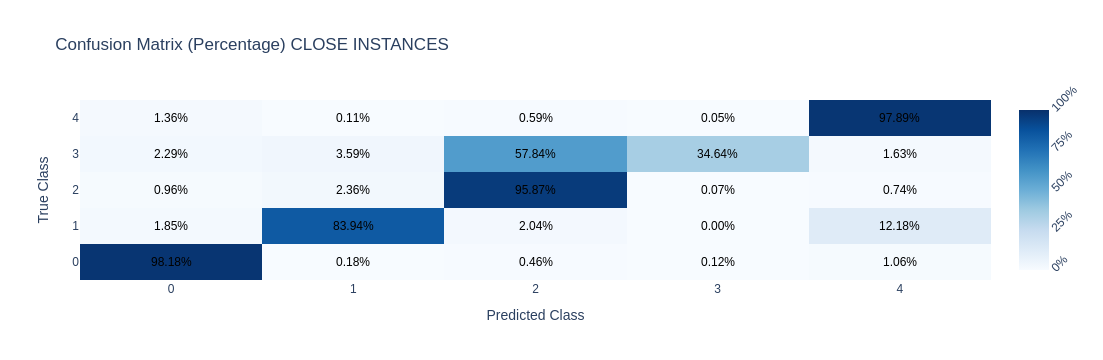

In [11]:
import plotly.graph_objects as go

# Assuming you have a DataFrame 'close_matches' with 'class' and 'class_truth' columns
conf_matrix_data = close_df[['class', 'class_truth']]

# Compute the confusion matrix
conf_matrix = pd.crosstab(conf_matrix_data['class_truth'], conf_matrix_data['class'], rownames=['True'], colnames=['Predicted'], normalize='index') * 100

# Create a heatmap
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix.values,
    x=conf_matrix.columns,
    y=conf_matrix.index,
    colorscale='Blues',  # You can change the color scale as needed
    hoverongaps=False,
    zmin=0,
    zmax=100,
    colorbar=dict(
        tickmode='array',
        tickvals=[0, 25, 50, 75, 100],
        ticktext=['0%', '25%', '50%', '75%', '100%'],
        tickangle=-45,
    )
))

# Add text annotations with percentage values
annotations = []
for i, true_class in enumerate(conf_matrix.index):
    for j, pred_class in enumerate(conf_matrix.columns):
        annotations.append(
            dict(
                x=pred_class,
                y=true_class,
                text=f'{conf_matrix.iloc[i, j]:.2f}%',  # Format as percentage with two decimal places
                showarrow=False,
                font=dict(color='black')  # Change the font color as needed
            )
        )

fig.update_layout(
    title='Confusion Matrix (Percentage) CLOSE INSTANCES',
    xaxis_title='Predicted Class',
    yaxis_title='True Class',
    annotations=annotations
)

# Show the figure
fig.show()


In [8]:
# FAR AWAY INSTANCES

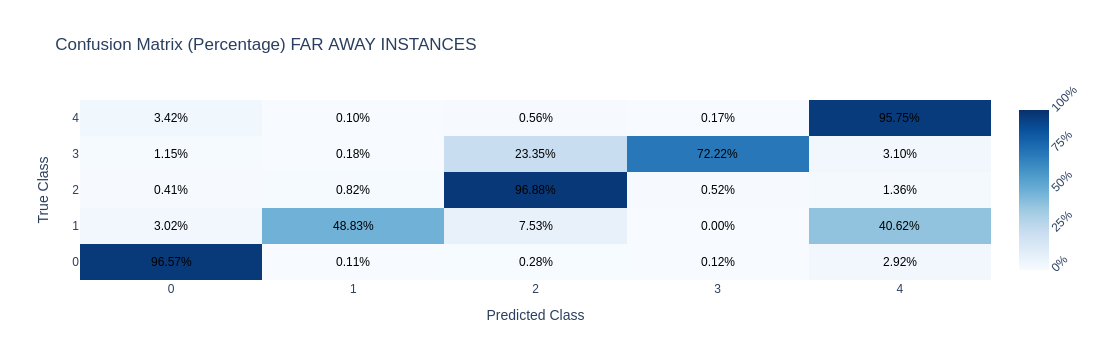

In [12]:
import plotly.graph_objects as go

# Assuming you have a DataFrame 'close_matches' with 'class' and 'class_truth' columns
conf_matrix_data = far_df[['class', 'class_truth']]

# Compute the confusion matrix
conf_matrix = pd.crosstab(conf_matrix_data['class_truth'], conf_matrix_data['class'], rownames=['True'], colnames=['Predicted'], normalize='index') * 100

# Create a heatmap
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix.values,
    x=conf_matrix.columns,
    y=conf_matrix.index,
    colorscale='Blues',  # You can change the color scale as needed
    hoverongaps=False,
    zmin=0,
    zmax=100,
    colorbar=dict(
        tickmode='array',
        tickvals=[0, 25, 50, 75, 100],
        ticktext=['0%', '25%', '50%', '75%', '100%'],
        tickangle=-45,
    )
))

# Add text annotations with percentage values
annotations = []
for i, true_class in enumerate(conf_matrix.index):
    for j, pred_class in enumerate(conf_matrix.columns):
        annotations.append(
            dict(
                x=pred_class,
                y=true_class,
                text=f'{conf_matrix.iloc[i, j]:.2f}%',  # Format as percentage with two decimal places
                showarrow=False,
                font=dict(color='black')  # Change the font color as needed
            )
        )

fig.update_layout(
    title='Confusion Matrix (Percentage) FAR AWAY INSTANCES',
    xaxis_title='Predicted Class',
    yaxis_title='True Class',
    annotations=annotations
)

# Show the figure
fig.show()
